In [ ]:
%%capture

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.stats import norm
from datetime import timedelta
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model

In [ ]:
# Список файлов .txt в указанной папке

# folder_path = '/content/drive/My Drive/Диссертация/Data_test'
folder_path = '/content/drive/My Drive/Диссертация/S_P_500_Options_data'
files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.txt')]

# Сплайны

In [ ]:
# Сплайны

total_success_vertical_spread = 0
total_success_butterfly_spread = 0
total_success_calendar_spread = 0

dates = []
option_per_day = []
variance_preservation = []
MSE = []
MAE = []

# Цикл по всем файлам
for file in files:
    try:
        data = pd.read_csv(file, delimiter=',', low_memory=False)
        data.columns = data.columns.str.strip().str.replace(r'[\[\]]', '', regex = True)

        # Получаем максимальную дату из файла
        selected_date = pd.to_datetime(data['QUOTE_DATE'].max())
        data['EXPIRE_DATE'] = pd.to_datetime(data['EXPIRE_DATE'])
        data['Tenor'] = ((data['EXPIRE_DATE'] - selected_date).dt.days / 365).round(2)
        data['QUOTE_DATE'] = pd.to_datetime(data['QUOTE_DATE'])
        data_one_day = data[data['QUOTE_DATE'].dt.date == selected_date.date()].copy()
        C_IV_Matrix = data_one_day[['STRIKE', 'C_IV', 'Tenor']].copy()
        C_IV_Matrix['STRIKE'] = pd.to_numeric(C_IV_Matrix['STRIKE'], errors='coerce')
        C_IV_Matrix['C_IV'] = pd.to_numeric(C_IV_Matrix['C_IV'], errors='coerce')

        # Создаем сводную таблицу (pivot table), используя цены колл-опционов как значения
        C_IV_Matrix = C_IV_Matrix.pivot_table(values='C_IV', index='STRIKE', columns='Tenor').dropna(inplace=False)
        Tenor = [round((i + 1) / 12, 4) for i in range(12)]
        Strike_center = data_one_day['UNDERLYING_LAST'].iloc[0]
        # Определяем процентные изменения относительно центрального значения Strike
        percent_changes = np.arange(-30, 32, 2) / 100  # От -30% до +30% с шагом 2%
        Strike = Strike_center * (1 + percent_changes)
        vols_surface_empty = pd.DataFrame(index=Strike, columns=Tenor)

        ##################################### Интерполяция #####################################
        X = C_IV_Matrix.columns.astype(float)
        Y = C_IV_Matrix.index.astype(float)
        Z = C_IV_Matrix.values
        interp_func = RectBivariateSpline(Y, X, Z, kx=1, ky=1) # linear
        # interp_func = RectBivariateSpline(Y, X, Z, kx=3, ky=3) # qubic
        # interp_func = RectBivariateSpline(Y, X, Z, kx=5, ky=5) # quintic
        empty_matrix_tenor = vols_surface_empty.columns.astype(float)
        empty_matrix_strike = vols_surface_empty.index.astype(float)
        interpolated_values = interp_func(empty_matrix_strike, empty_matrix_tenor, grid=True)
        vols_surface_interpolated = pd.DataFrame(interpolated_values, index=vols_surface_empty.index, columns=vols_surface_empty.columns)
        vols_surface_interpolated.index.name = 'Strike'
        vols_surface_interpolated.columns.name = 'Tenor'

        ##################################### Расчет цен опционов #####################################
        # Расчет цен Call опционов с интерполированной implied volatility
        def black_scholes_call(S, K, r, T, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            return call_price

        # Процентная ставка теперь равна загруженной процентной ставке
        ticker = "^TNX"  # Тикер для 10-летних государственных облигаций
        start_date = selected_date - timedelta(days=7)
        end_date = selected_date
        interest_rate_data = yf.download(ticker, start=start_date, end=end_date)
        r = interest_rate_data['Adj Close'].iloc[-1] / 100

        call_prices = pd.DataFrame(index=vols_surface_interpolated.index, columns=vols_surface_interpolated.columns)
        for tenor in vols_surface_interpolated.columns:
            for strike in vols_surface_interpolated.index:
                volatility = vols_surface_interpolated.loc[strike, tenor]
                call_prices.loc[strike, tenor] = black_scholes_call(data_one_day['UNDERLYING_LAST'].iloc[0], strike, r, tenor, volatility)

        ##################################### Проверка по спредам #####################################
        # Вертикальный
        vertical_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(len(call_prices.index) - 1):
            spread_value.iloc[i, :] = (call_prices.iloc[i, :] - call_prices.iloc[i + 1, :]) / (
                    call_prices.index[i + 1] - call_prices.index[i])
            spread_value = spread_value.fillna(0).astype(int)
            vertical_check = (spread_value >= 0) & (spread_value <= 1)

            if vertical_check.all().all() and not vertical_spread_success_flag:
                total_success_vertical_spread += 1
                vertical_spread_success_flag = True

        # Бабочка
        butterfly_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(1, len(call_prices) - 1):
            spread_value.iloc[i, :] = call_prices.iloc[i - 1, :] - (
                call_prices.iloc[i, :] * ((call_prices.index[i + 1] - call_prices.index[i - 1]) / (
                    call_prices.index[i + 1] - call_prices.index[i]))) + (
                                        call_prices.iloc[i + 1, :] * (
                                            (call_prices.index[i] - call_prices.index[i - 1]) / (
                                                call_prices.index[i + 1] - call_prices.index[i])))
            spread_value = spread_value.fillna(0).astype(int)
            butterfly_check = (spread_value >= 0)

            if butterfly_check.all().all() and not butterfly_spread_success_flag:
                total_success_butterfly_spread += 1
                butterfly_spread_success_flag = True

        # Календарный
        calendar_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(len(call_prices.columns) - 1):
            spread_value.iloc[:, i] = call_prices.iloc[:, i + 1] - call_prices.iloc[:, i]
            spread_value = spread_value.fillna(0).astype(int)
            calendar_check = (spread_value >= 0)

            if calendar_check.all().all() and not calendar_spread_success_flag:
                total_success_calendar_spread += 1
                calendar_spread_success_flag = True

        # Объект с датами
        dates.append(selected_date)

        # Опционов в день в матрице C_IV_Matrix
        options_in_i_day = C_IV_Matrix.shape[0] * C_IV_Matrix.shape[1]
        option_per_day.append(options_in_i_day)

        # Доля сохраненной дисперсии
        variance_share = vols_surface_interpolated.var().sum() / C_IV_Matrix.var().sum()
        variance_preservation.append(variance_share)

        # Расчет MSE
        min_rows = min(vols_surface_interpolated.shape[0], C_IV_Matrix.shape[0])
        min_cols = min(vols_surface_interpolated.shape[1], C_IV_Matrix.shape[1])
        vols_surface_interpolated_resized = vols_surface_interpolated.iloc[:min_rows, :min_cols]
        C_IV_Matrix_resized = C_IV_Matrix.iloc[:min_rows, :min_cols]
        MSE_calc = mean_squared_error(C_IV_Matrix_resized.values.flatten(), vols_surface_interpolated_resized.values.flatten())
        MSE.append(MSE_calc)

        # Расчет MAE
        MAE_calc = mean_absolute_error(C_IV_Matrix_resized.values.flatten(), vols_surface_interpolated_resized.values.flatten())
        MAE.append(MAE_calc)

    except Exception as e:
      print(f"Ошибка при обработке файла {file}: {e}")
      continue

recovered_data = {
    'option_per_day': option_per_day,
    'variance_preservation': variance_preservation,
    'MSE': MSE,
    'MAE': MAE
}

recovered_data = pd.DataFrame(recovered_data, index=dates)

total_files = len(files)
print("Vertical Spread Success Rate:", total_success_vertical_spread / total_files * 100, "%")
print("Butterfly Spread Success Rate:", total_success_butterfly_spread / total_files * 100, "%")
print("Calendar Spread Success Rate:", total_success_calendar_spread / total_files * 100, "%")

recovered_data

[*********************100%%**********************]  1 of 1 completed


Vertical Spread Success Rate: 100.0 %
Butterfly Spread Success Rate: 100.0 %
Calendar Spread Success Rate: 100.0 %


,option_per_day,variance_preservation,MSE,MAE
2023-06-30,1110,0.000991,10.719998,1.326951


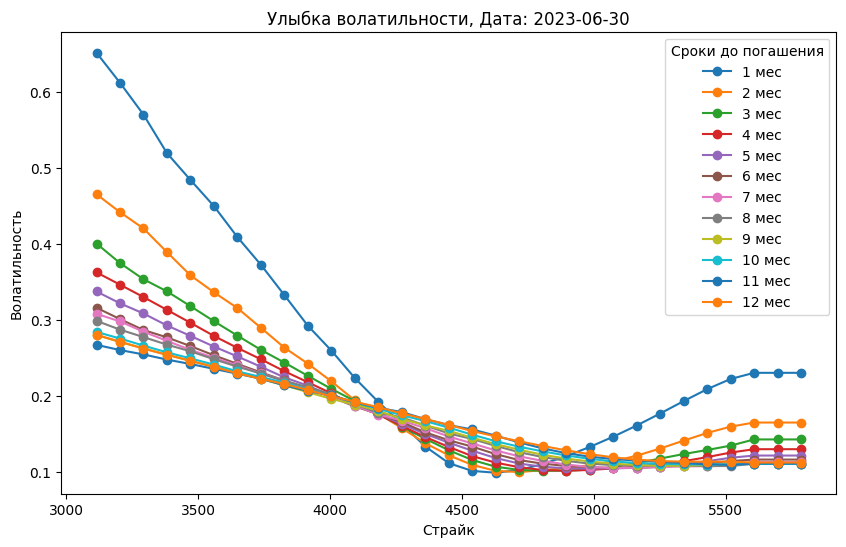

In [ ]:
# Переименование столбцов от 1 до 12
vols_surface_interpolated_renamed = vols_surface_interpolated.rename(columns={col: i + 1 for i, col in enumerate(vols_surface_interpolated.columns)})

# Построение графика улыбки волатильности
plt.figure(figsize=(10, 6))
for col in vols_surface_interpolated_renamed.columns:
    plt.plot(vols_surface_interpolated.index, vols_surface_interpolated_renamed[col], marker='o', label=f'{col} мес')

plt.xlabel('Страйк')
plt.ylabel('Волатильность')
plt.title('Улыбка волатильности, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')))
plt.legend(title='Сроки до погашения')
plt.grid(False)
plt.savefig('volatility_smile.svg', format='svg', dpi=1500)
plt.show()

# CNN

In [ ]:
# CNN
from tensorflow.keras import regularizers
total_success_vertical_spread = 0
total_success_butterfly_spread = 0
total_success_calendar_spread = 0

dates = []
option_per_day = []
variance_preservation = []
MSE = []
MAE = []

# Цикл по всем файлам
for file in files:
    try:
        data = pd.read_csv(file, delimiter=',', low_memory=False)
        data.columns = data.columns.str.strip().str.replace(r'[\[\]]', '', regex = True)

        # Получаем максимальную дату из файла
        selected_date = pd.to_datetime(data['QUOTE_DATE'].max())
        data['EXPIRE_DATE'] = pd.to_datetime(data['EXPIRE_DATE'])
        data['Tenor'] = ((data['EXPIRE_DATE'] - selected_date).dt.days / 365).round(2)
        data['QUOTE_DATE'] = pd.to_datetime(data['QUOTE_DATE'])
        data_one_day = data[data['QUOTE_DATE'].dt.date == selected_date.date()].copy()
        C_IV_Matrix = data_one_day[['STRIKE', 'C_IV', 'Tenor']].copy()
        C_IV_Matrix['STRIKE'] = pd.to_numeric(C_IV_Matrix['STRIKE'], errors='coerce')
        C_IV_Matrix['C_IV'] = pd.to_numeric(C_IV_Matrix['C_IV'], errors='coerce')

        # Создаем сводную таблицу (pivot table), используя цены колл-опционов как значения
        C_IV_Matrix = C_IV_Matrix.pivot_table(values='C_IV', index='STRIKE', columns='Tenor').dropna(inplace=False)
        Tenor = [round((i + 1) / 12, 4) for i in range(12)]
        Strike_center = data_one_day['UNDERLYING_LAST'].iloc[0]
        # Определяем процентные изменения относительно центрального значения Strike
        percent_changes = np.arange(-30, 32, 2) / 100  # От -30% до +30% с шагом 2%
        Strike = Strike_center * (1 + percent_changes)
        vols_surface_empty = pd.DataFrame(index=Strike, columns=Tenor)

        ##################################### Интерполяция #####################################
        X = C_IV_Matrix.columns.astype(float)
        Y = C_IV_Matrix.index.astype(float)
        Z = C_IV_Matrix.values

        # Преобразование входных данных в формат изображения
        Z_image = np.expand_dims(Z, axis=-1)

        # Создание модели CNN
        input_layer = layers.Input(shape=(Z_image.shape[0], Z_image.shape[1], 1))
        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        maxpool1 = layers.MaxPooling2D((2, 2))(conv1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(maxpool1)
        maxpool2 = layers.MaxPooling2D((2, 2))(conv2)
        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(maxpool2)
        maxpool3 = layers.MaxPooling2D((2, 2))(conv3)
        # Добавляем слой внимания
        attention_probs = layers.Attention()([maxpool3, maxpool3])
        # Преобразование и выходные слои
        flatten = layers.Flatten()(attention_probs)
        dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten)
        dropout1 = layers.Dropout(0.5)(dense1)
        dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
        dropout2 = layers.Dropout(0.5)(dense2)
        output = layers.Dense(len(empty_matrix_tenor) * len(empty_matrix_strike))(dropout2)

        # Сборка модели
        model = Model(inputs=input_layer, outputs=output)

        # Компиляция модели
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Обучение модели
        model.fit(np.expand_dims(Z_image, axis=0), np.expand_dims(interpolated_values.flatten(), axis=0), epochs=10)

        # Получение предсказанных значений
        predicted_values = model.predict(np.expand_dims(Z_image, axis=0))

        # Применение функции clip для ограничения значений
        min_value = 1e-6  # Минимальное значение
        max_value = np.inf  # Максимальное значение (бесконечность)
        predicted_values_clipped = np.clip(predicted_values, min_value, max_value)

        # Преобразование предсказанных значений обратно в двумерный формат
        predicted_values_reshaped = predicted_values_clipped.reshape(len(empty_matrix_strike), len(empty_matrix_tenor))

        # Создание DataFrame с предсказанными значениями
        vols_surface_interpolated = pd.DataFrame(predicted_values_reshaped, index=vols_surface_empty.index, columns=vols_surface_empty.columns)
        vols_surface_interpolated.index.name = 'Strike'
        vols_surface_interpolated.columns.name = 'Tenor'

        ##################################### Расчет цен опционов #####################################
        # Расчет цен Call опционов с интерполированной implied volatility
        def black_scholes_call(S, K, r, T, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            return call_price

        # Процентная ставка теперь равна загруженной процентной ставке
        ticker = "^TNX"  # Тикер для 10-летних государственных облигаций
        start_date = selected_date - timedelta(days=7)
        end_date = selected_date
        interest_rate_data = yf.download(ticker, start=start_date, end=end_date)
        r = interest_rate_data['Adj Close'].iloc[-1] / 100

        call_prices = pd.DataFrame(index=vols_surface_interpolated.index, columns=vols_surface_interpolated.columns)
        for tenor in vols_surface_interpolated.columns:
            for strike in vols_surface_interpolated.index:
                volatility = vols_surface_interpolated.loc[strike, tenor]
                call_prices.loc[strike, tenor] = black_scholes_call(data_one_day['UNDERLYING_LAST'].iloc[0], strike, r, tenor, volatility)

        ##################################### Проверка по спредам #####################################
        # Вертикальный
        vertical_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(len(call_prices.index) - 1):
            spread_value.iloc[i, :] = (call_prices.iloc[i, :] - call_prices.iloc[i + 1, :]) / (
                    call_prices.index[i + 1] - call_prices.index[i])
            spread_value = spread_value.fillna(0).astype(int)
            vertical_check = (spread_value >= 0) & (spread_value <= 1)

            if vertical_check.all().all() and not vertical_spread_success_flag:
                total_success_vertical_spread += 1
                vertical_spread_success_flag = True

        # Бабочка
        butterfly_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(1, len(call_prices) - 1):
            spread_value.iloc[i, :] = call_prices.iloc[i - 1, :] - (
                call_prices.iloc[i, :] * ((call_prices.index[i + 1] - call_prices.index[i - 1]) / (
                    call_prices.index[i + 1] - call_prices.index[i]))) + (
                                        call_prices.iloc[i + 1, :] * (
                                            (call_prices.index[i] - call_prices.index[i - 1]) / (
                                                call_prices.index[i + 1] - call_prices.index[i])))
            spread_value = spread_value.fillna(0).astype(int)
            butterfly_check = (spread_value >= 0)

            if butterfly_check.all().all() and not butterfly_spread_success_flag:
                total_success_butterfly_spread += 1
                butterfly_spread_success_flag = True

        # Календарный
        calendar_spread_success_flag = False
        spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
        for i in range(len(call_prices.columns) - 1):
            spread_value.iloc[:, i] = call_prices.iloc[:, i + 1] - call_prices.iloc[:, i]
            spread_value = spread_value.fillna(0).astype(int)
            calendar_check = (spread_value >= 0)

            if calendar_check.all().all() and not calendar_spread_success_flag:
                total_success_calendar_spread += 1
                calendar_spread_success_flag = True

        # Объект с датами
        dates.append(selected_date)

        # Опционов в день в матрице C_IV_Matrix
        options_in_i_day = C_IV_Matrix.shape[0] * C_IV_Matrix.shape[1]
        option_per_day.append(options_in_i_day)

        # Доля сохраненной дисперсии
        variance_share = vols_surface_interpolated.var().sum() / C_IV_Matrix.var().sum()
        variance_preservation.append(variance_share)

        # Расчет MSE
        min_rows = min(vols_surface_interpolated.shape[0], C_IV_Matrix.shape[0])
        min_cols = min(vols_surface_interpolated.shape[1], C_IV_Matrix.shape[1])
        vols_surface_interpolated_resized = vols_surface_interpolated.iloc[:min_rows, :min_cols]
        C_IV_Matrix_resized = C_IV_Matrix.iloc[:min_rows, :min_cols]
        MSE_calc = mean_squared_error(C_IV_Matrix_resized.values.flatten(), vols_surface_interpolated_resized.values.flatten())
        MSE.append(MSE_calc)

        # Расчет MAE
        MAE_calc = mean_absolute_error(C_IV_Matrix_resized.values.flatten(), vols_surface_interpolated_resized.values.flatten())
        MAE.append(MAE_calc)

    except Exception as e:
      print(f"Ошибка при обработке файла {file}: {e}")
      continue

recovered_data = {
    'option_per_day': option_per_day,
    'variance_preservation': variance_preservation,
    'MSE': MSE,
    'MAE': MAE
}

recovered_data = pd.DataFrame(recovered_data, index=dates)

total_files = len(files)
print("Vertical Spread Success Rate:", total_success_vertical_spread / total_files * 100, "%")
print("Butterfly Spread Success Rate:", total_success_butterfly_spread / total_files * 100, "%")
print("Calendar Spread Success Rate:", total_success_calendar_spread / total_files * 100, "%")

recovered_data

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 3.4076
Epoch 2/10
1/1 [==============================] - 0s 21ms/step - loss: 3.1457
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 3.0528
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 2.9250
Epoch 5/10
1/1 [==============================] - 0s 22ms/step - loss: 2.8188
Epoch 6/10
1/1 [==============================] - 0s 18ms/step - loss: 2.7107
Epoch 7/10
1/1 [==============================] - 0s 17ms/step - loss: 2.6156
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 2.5207
Epoch 9/10
1/1 [==============================] - 0s 16ms/step - loss: 2.4255
Epoch 10/10
1/1 [==============================] - 0s 109ms/step


[*********************100%%**********************]  1 of 1 completed


Vertical Spread Success Rate: 100.0 %
Butterfly Spread Success Rate: 100.0 %
Calendar Spread Success Rate: 100.0 %


,option_per_day,variance_preservation,MSE,MAE
2023-06-30,1110,0.000019,11.664115,1.501606


In [ ]:
# Среднее количество опционов за день в матрице C_IV

# recovered_data.option_per_day.mean()
# 574.2291666666666

In [ ]:
# linear
# Vertical Spread Success Rate: 98.18181818181819 %
# Butterfly Spread Success Rate: 92.12121212121212 %
# Calendar Spread Success Rate: 97.57575757575758 %

# qubic
# Vertical Spread Success Rate: 93.33333333333333 %
# Butterfly Spread Success Rate: 81.81818181818183 %
# Calendar Spread Success Rate: 91.51515151515152 %

# quintic
# Vertical Spread Success Rate: 84.24242424242424 %
# Butterfly Spread Success Rate: 72.72727272727273 %
# Calendar Spread Success Rate: 78.18181818181819 %

#CNN
# Vertical Spread Success Rate: 72.12121212121212 %
# Butterfly Spread Success Rate: 72.12121212121212 %
# Calendar Spread Success Rate: 58.78787878787879 %

In [ ]:
# Сохранение recovered_data

# file_path = '/content/drive/My Drive/Диссертация/CNN_1.csv'
# recovered_data.to_csv(file_path, index=True)

In [ ]:
# Средние

cnn = pd.read_csv('/content/drive/MyDrive/Диссертация/CNN_1.csv')
print(cnn.mean())

linear_spline = pd.read_csv('/content/drive/MyDrive/Диссертация/linear_spline.csv')
print(linear_spline.mean())

qubic_spline = pd.read_csv('/content/drive/MyDrive/Диссертация/qubic_spline.csv')
print(qubic_spline.mean())

quintic_spline = pd.read_csv('/content/drive/MyDrive/Диссертация/quintic_spline.csv')
print(quintic_spline.mean())

<ipython-input-5-b579bca120ed>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(cnn.mean())


option_per_day           664.773109
variance_preservation      0.226614
MSE                        0.298160
MAE                        0.189450
dtype: float64


<ipython-input-5-b579bca120ed>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(linear_spline.mean())


option_per_day           515.447853
variance_preservation      0.156084
MSE                        0.191795
MAE                        0.130824
dtype: float64


<ipython-input-5-b579bca120ed>:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(qubic_spline.mean())


option_per_day           536.717949
variance_preservation      0.163920
MSE                        0.200227
MAE                        0.135188
dtype: float64
option_per_day           574.229167
variance_preservation      3.318608
MSE                        0.474794
MAE                        0.162058
dtype: float64


<ipython-input-5-b579bca120ed>:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(quintic_spline.mean())


# Графики

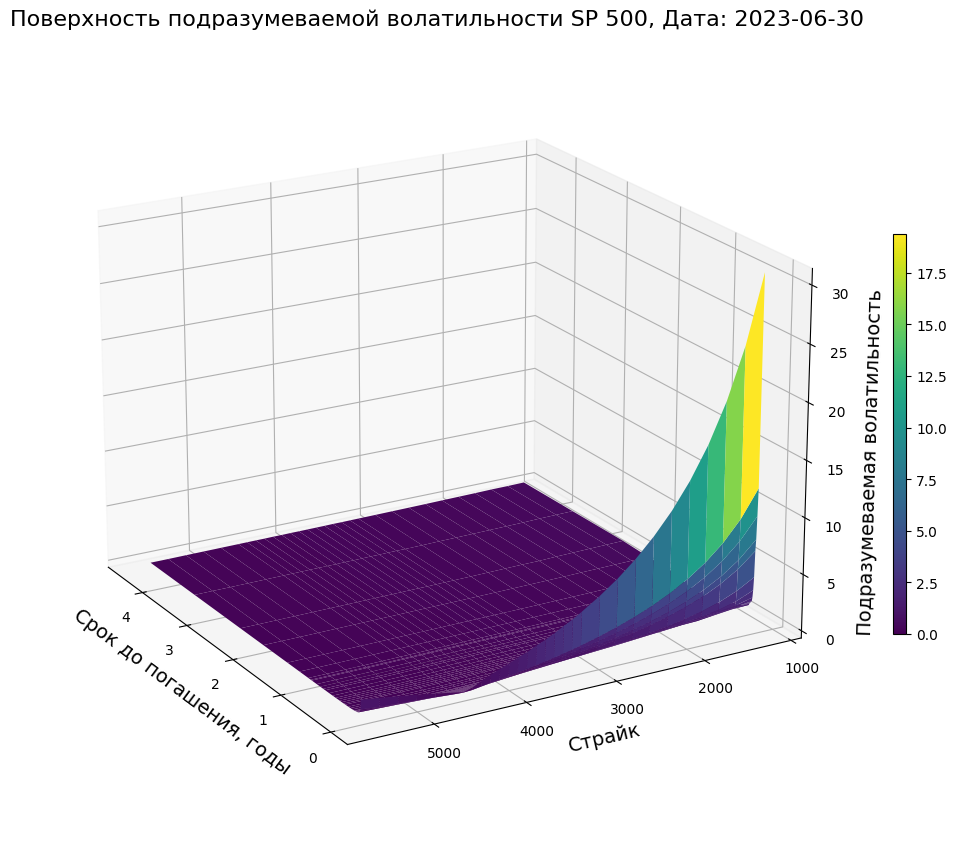

In [ ]:
# Получение индексов Strike в обратном порядке
sorted_Y = np.flip(C_IV_Matrix.index.astype(float))

# Создание сетки
X, Y = np.meshgrid(C_IV_Matrix.columns.astype(float), sorted_Y)
Z = C_IV_Matrix.loc[sorted_Y].values

# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=5)
ax.set_ylabel('Страйк', fontsize=14, labelpad=5)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Поверхность подразумеваемой волатильности SP 500, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)

# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=30)

# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)

# Уменьшение рамки рисунка
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Сохранение графика в формате SVG
plt.savefig('volatility_surface.svg', format='svg', dpi=1500)
plt.show()

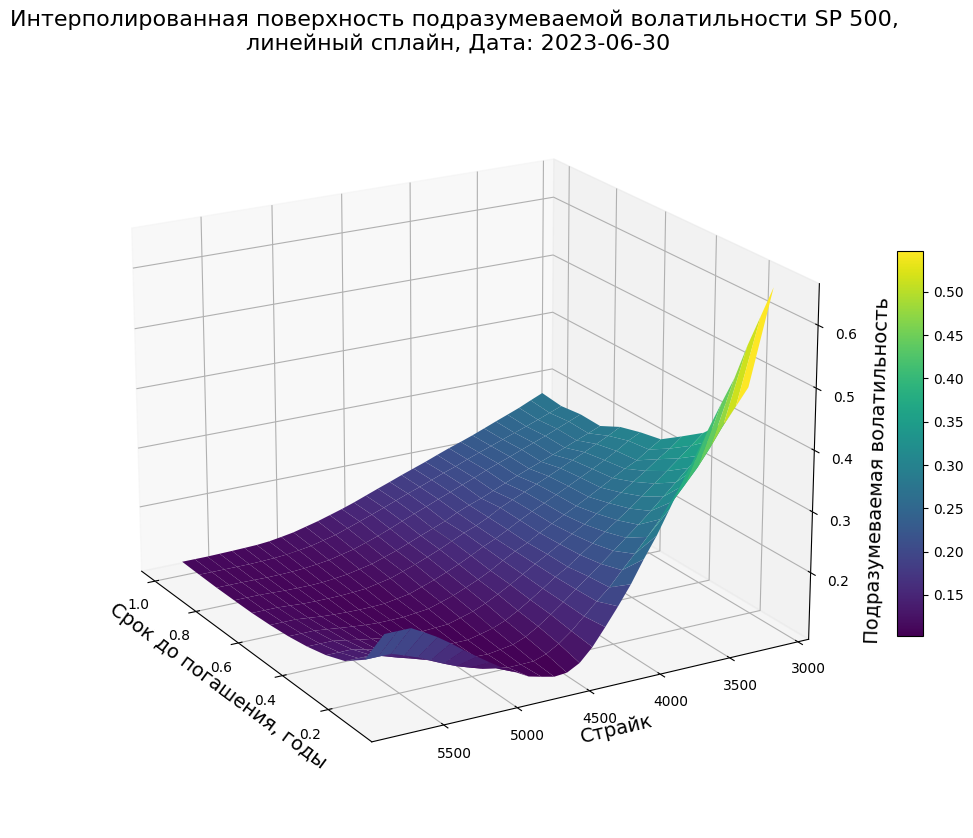

In [ ]:
# График интерполированной поверхности волатильности

X = vols_surface_interpolated.columns.astype(float)
Y = vols_surface_interpolated.index.astype(float)
Z = vols_surface_interpolated.values
X, Y = np.meshgrid(X, Y)
# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=1)
ax.set_ylabel('Страйк', fontsize=14, labelpad=1)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Интерполированная поверхность подразумеваемой волатильности SP 500, \n'
             'линейный сплайн, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)
# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=15)
# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)
# Сохранение графика в формате SVG
plt.savefig('intervolatility_surface_linear_spline.svg', format='svg', dpi = 1500)
plt.show()

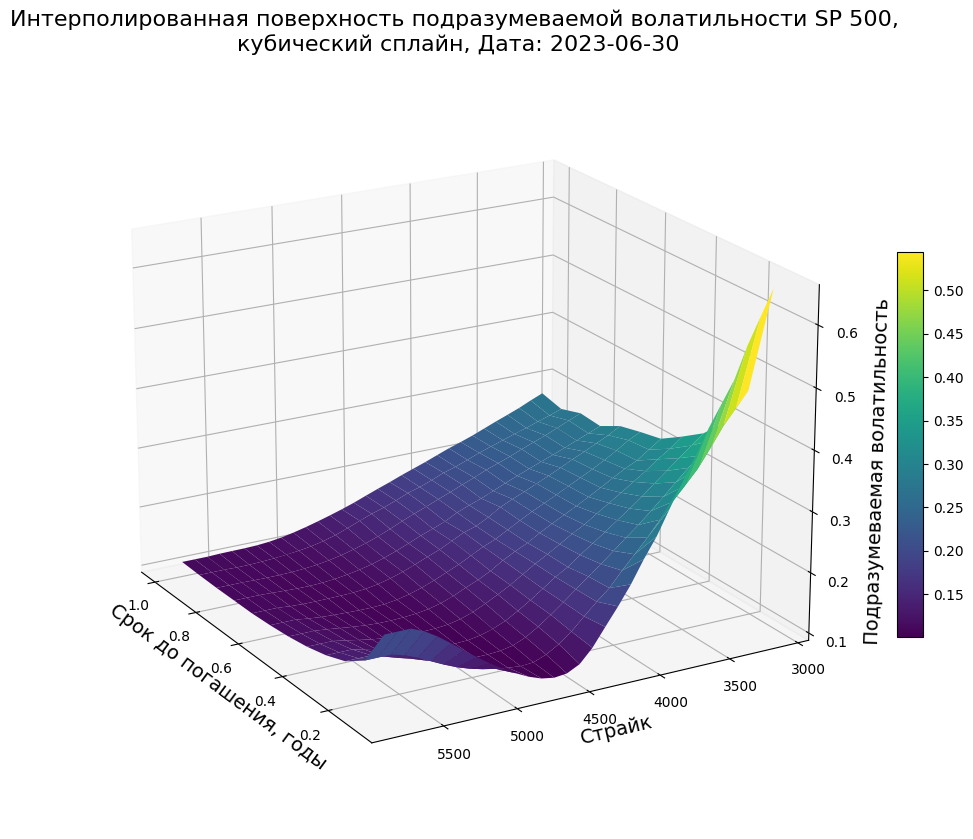

In [ ]:
# куб сплайн

X = vols_surface_interpolated.columns.astype(float)
Y = vols_surface_interpolated.index.astype(float)
Z = vols_surface_interpolated.values
X, Y = np.meshgrid(X, Y)
# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=1)
ax.set_ylabel('Страйк', fontsize=14, labelpad=1)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Интерполированная поверхность подразумеваемой волатильности SP 500, \n'
             'кубический сплайн, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)
# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=15)
# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)
# Сохранение графика в формате SVG
plt.savefig('intervolatility_surface_qubic_spline.svg', format='svg', dpi = 1500)
plt.show()

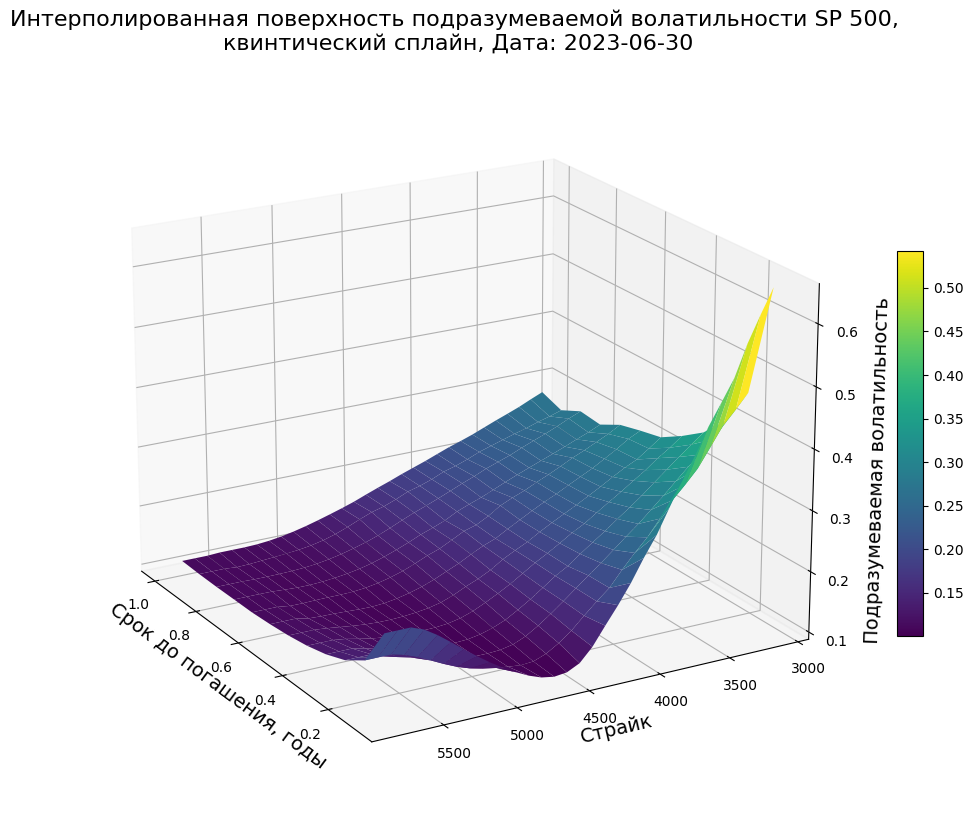

In [ ]:
# квинт сплайн

X = vols_surface_interpolated.columns.astype(float)
Y = vols_surface_interpolated.index.astype(float)
Z = vols_surface_interpolated.values
X, Y = np.meshgrid(X, Y)
# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=1)
ax.set_ylabel('Страйк', fontsize=14, labelpad=1)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Интерполированная поверхность подразумеваемой волатильности SP 500, \n'
             'квинтический сплайн, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)
# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=15)
# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)
# Сохранение графика в формате SVG
plt.savefig('intervolatility_surface_quintic_spline.svg', format='svg', dpi = 1500)
plt.show()

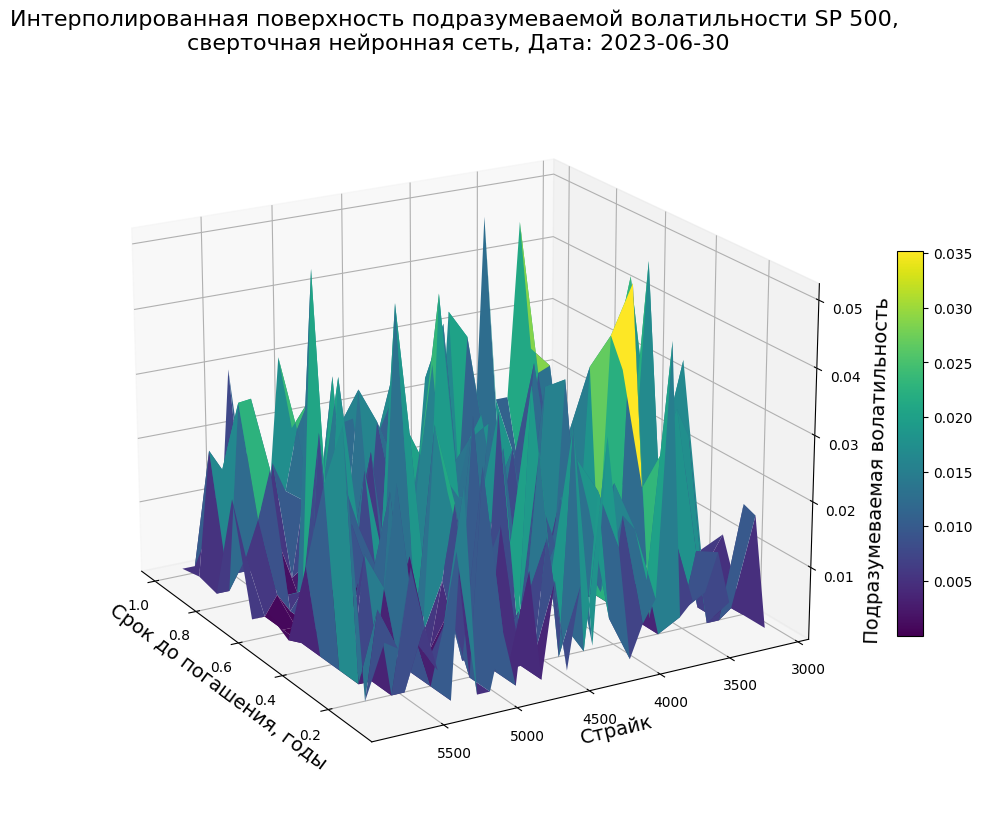

In [ ]:
# CNN

X = vols_surface_interpolated.columns.astype(float)
Y = vols_surface_interpolated.index.astype(float)
Z = vols_surface_interpolated.values
X, Y = np.meshgrid(X, Y)
# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=1)
ax.set_ylabel('Страйк', fontsize=14, labelpad=1)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Интерполированная поверхность подразумеваемой волатильности SP 500, \n'
             'сверточная нейронная сеть, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)
# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=15)
# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)
# Сохранение графика в формате SVG
plt.savefig('intervolatility_surface_cnn.svg', format='svg', dpi = 1500)
plt.show()